# Detectron2: Come utilizzare un modello di Computer Vision in inferenza.
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

Questo notebook è stato adattato dal tutorial uffciale consultabile al seguente [link](https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5)

## Installa Detectron2 (valido solo su Google Colab)

> **Importante**: se stai utilizzando un computer locale, assicurati di seguire il file [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md).
Questo notebook include solo ciò che è necessario per l'esecuzione in Colab.

In [1]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 3.8 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-pjet9onx
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-pjet9onx
  Resolved https://github.com/facebookresearch/detectron2.git to commit 10d074bfecc81653548511bf6eb903942ef32988
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50

In [2]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.1 ; cuda:  cu121
detectron2: 0.6


# Utilizzo di un modello 'pre-trained' in inferenza

In [3]:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import cv2

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Dobbiamo prima caricare un'immagine su cui effettuare le previsioni.

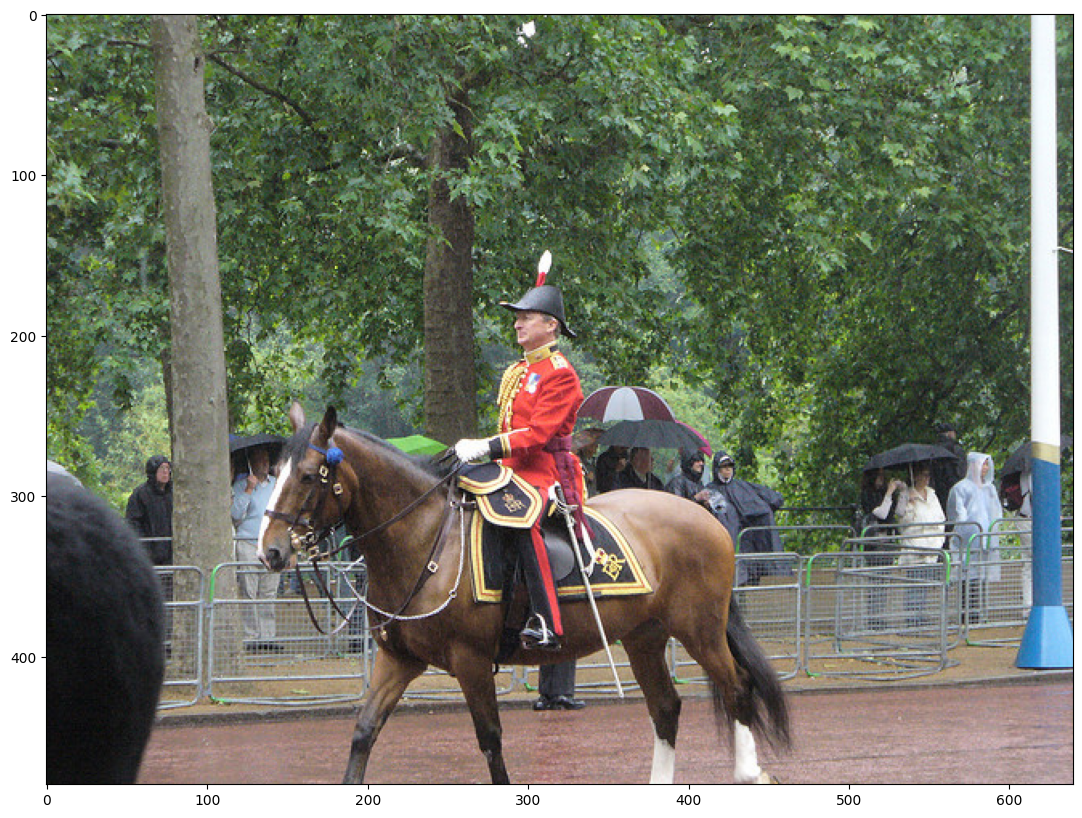

In [4]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg
im = cv2.imread("./input.jpg")
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

## Object detection.
L'obiettivo sarà quello di andare ad 'individuare' gli oggetti presenti nell'immagine.

Quindi, creiamo una configurazione di detector2 e un `DefaultPredictor` di detector2 per eseguire l'inferenza su questa immagine.

In [5]:
# Create config
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

In [6]:
# Create predictor
predictor = DefaultPredictor(cfg)

# Make prediction
outputs = predictor(im)

[03/05 11:56:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl ...


model_final_f6e8b1.pkl: 243MB [00:01, 131MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


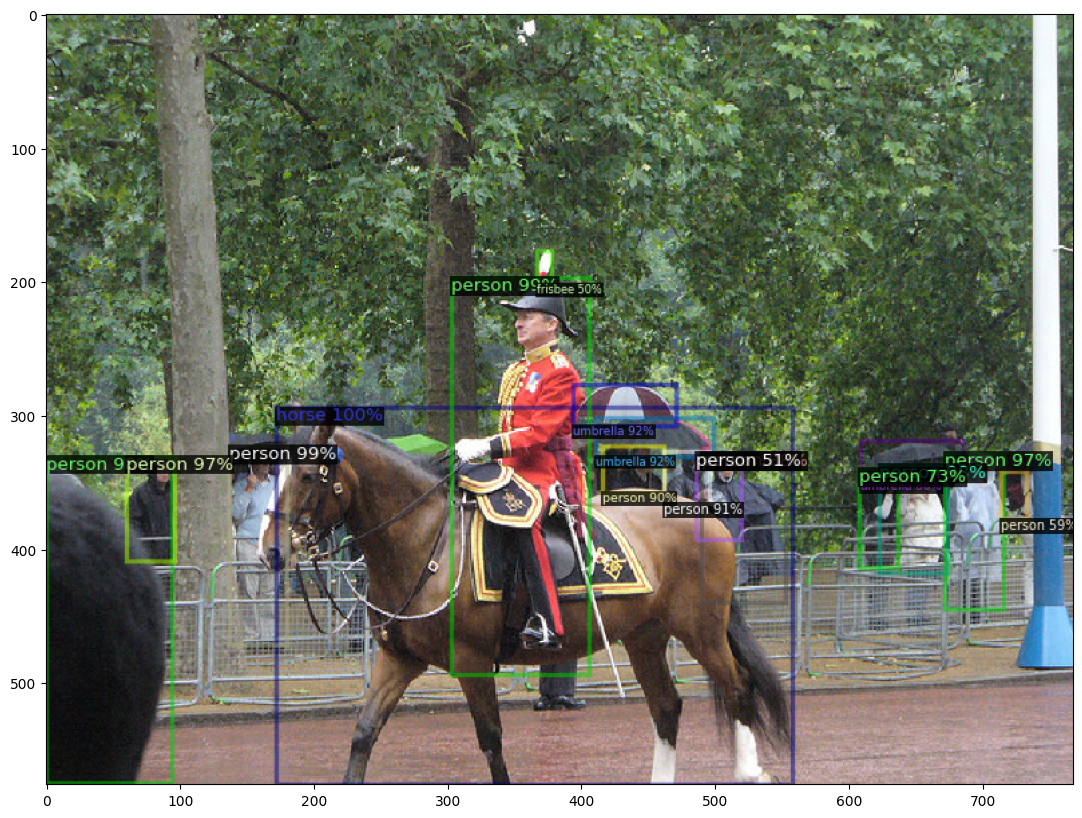

In [7]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

## Instance Segmentation

Passare dal rilevamento degli oggetti alla segmentazione delle istanze è semplicissimo. Dobbiamo solo modificare il file di configurazione e i pesi del modello.

In [8]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

In [9]:
# Create predictor
predictor = DefaultPredictor(cfg)

# Make prediction
outputs = predictor(im)

[03/05 11:57:10 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:01, 128MB/s]                           


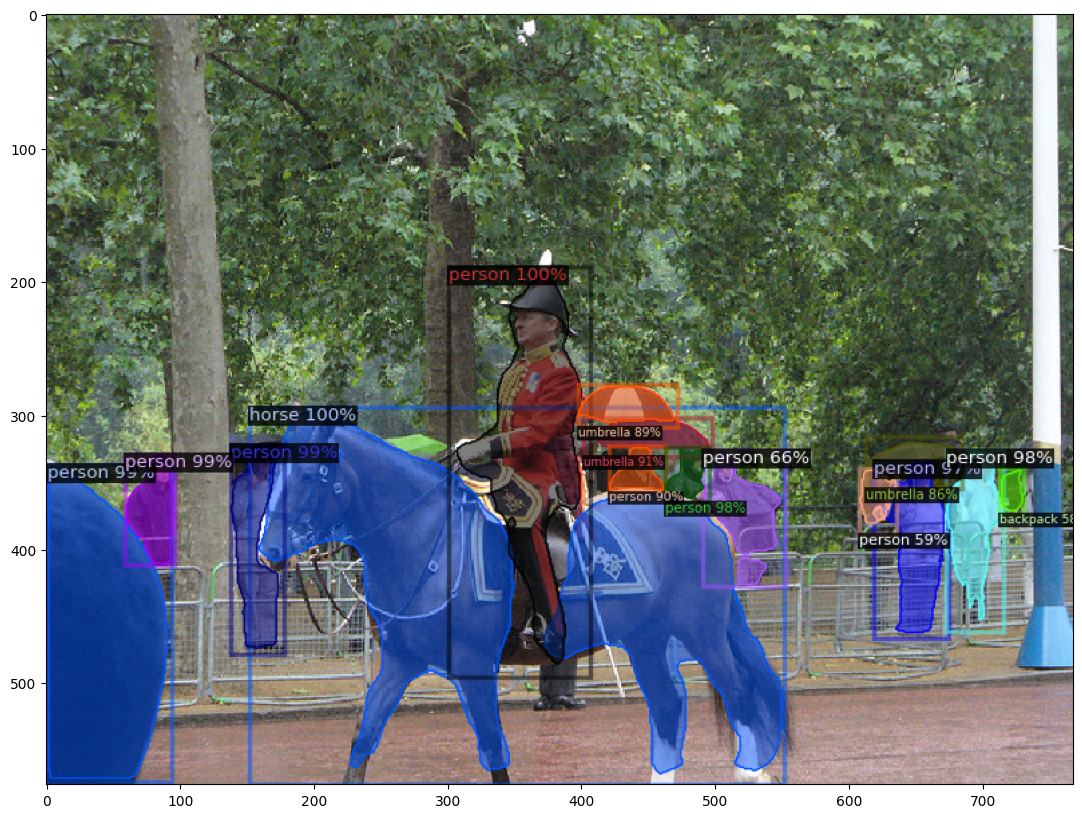

In [10]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

## Keypoint detection
In questo caso andiamo ad evidenziare lo 'skeleton' delle persone presenti nella scena.

[03/05 11:57:25 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...


model_final_a6e10b.pkl: 237MB [00:02, 88.8MB/s]                          


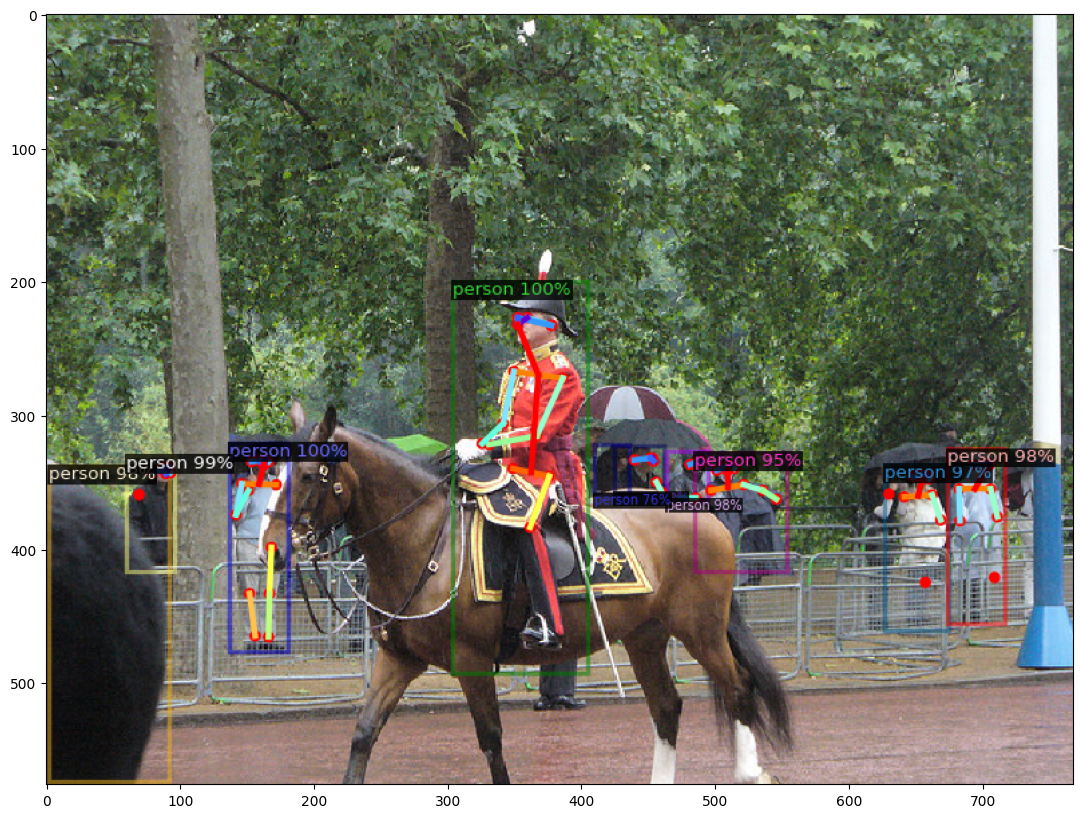

In [11]:
# Inference with a keypoint detection model
cfg = get_cfg()   # get a fresh new config
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))

# Video analisi
Andiamo adesso a calcolare lo **skeleton** all'interno di un video.

In [12]:
import numpy as np
import tqdm

# import some common detectron2 utilities
from detectron2.utils.video_visualizer import VideoVisualizer
from detectron2.utils.visualizer import ColorMode
import time

# Extract video properties
video = cv2.VideoCapture('video-input.mp4')
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
frames_per_second = video.get(cv2.CAP_PROP_FPS)
num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))

# Initialize video writer
video_writer = cv2.VideoWriter('out.mp4', fourcc=cv2.VideoWriter_fourcc(*"mp4v"), fps=float(frames_per_second), frameSize=(width, height), isColor=True)

# Initialize predictor
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

# Initialize visualizer
v = VideoVisualizer(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), ColorMode.IMAGE)

def runOnVideo(video, maxFrames):
    """ Runs the predictor on every frame in the video (unless maxFrames is given),
    and returns the frame with the predictions drawn.
    """

    readFrames = 0
    while True:
        hasFrame, frame = video.read()
        if not hasFrame:
            break

        # Get prediction results for this frame
        outputs = predictor(frame)

        # Make sure the frame is colored
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)

        # Draw a visualization of the predictions using the video visualizer
        visualization = v.draw_instance_predictions(frame, outputs["instances"].to("cpu"))

        # Convert Matplotlib RGB format to OpenCV BGR format
        visualization = cv2.cvtColor(visualization.get_image(), cv2.COLOR_RGB2BGR)

        yield visualization

        readFrames += 1
        if readFrames > maxFrames:
            break

# Create a cut-off for debugging
num_frames = 120

# Enumerate the frames of the video
for visualization in tqdm.tqdm(runOnVideo(video, num_frames), total=num_frames):

    # Write test image
    cv2.imwrite('POSE detectron2.png', visualization)

    # Write to video file
    video_writer.write(visualization)

# Release resources
video.release()
video_writer.release()
cv2.destroyAllWindows()

[03/05 11:58:15 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...


121it [00:43,  2.75it/s]
